## Implementation of DDPG paper inspired from: [DDPG Video by Machine learning with phil](https://www.youtube.com/watch?v=jDll4JSI-xo)

## Some notes from DDPG paper for implementation purposes
- Need a replay buffer class
- Need a class for target Q network (function of s,a)
- Need to use batch norm
- Use off-policy learning (learn from behavioural policy B = mu(s)) to handle explore-exploit dilemma as policy becomes deterministic
- Deterministic policies means the algorithm outputs the actual policies instead of probabilities. Need a way to bound actions to env limits
- Two actor and two critic networks (two on-policy, two off-policy), one target network for each 
- Updates are soft, according to theta_prime = tau*theta + (1-tau)*theta_prime, with tau << 1 (0.01 or less)
- The target actor is just the evaluation actior + noise (ornstein ulhenbeck) -> need a class for noise
- Action chosen as per target network
- ai is from the action buffer
- Adam optimiser, lr = 10^-4 for actor, 10^-3 for critic
- For Q(critic), L2 weight decay of 10^-2 and gamma = 0.99
- For soft updates, tau = 0.001
- Relu for all hidden layers
- final output layer for actor -> tanh 
- action as separate input to second hidden layer of Q
- final layer weights and biases uniform distribution in a range
- theta = 0.15, sigma = 0.2 for noise (ornstein ulhenbeck)


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym

In [2]:
import matplotlib.pyplot as plt 
import numpy as np

def plotLearning(scores, filename, x=None, window=5):   
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel('Score')       
    plt.xlabel('Game')                     
    plt.plot(x, running_avg)
    plt.savefig(filename)

In [3]:
# ornstein-uhlenbeck noise class
class OUNoise(object):
    def __init__(self, mu, sigma=0.15, theta=0.2,dt = 1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()
    
    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x
    
    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [4]:
# replay buffer class
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_counter = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)
    
    def store_transitions(self, state, action, reward, state_, done):
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = 1-int(done)
        self.mem_counter+=1

    def sample_buffer(self, batch_size):
        max_memory = min(self.mem_counter, self.mem_size)
        batch = np.random.choice(max_memory, batch_size)

        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, new_states, terminal
    

In [5]:
# class for critic network
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name, chkpt_dir = 'models/ddpg'):
        super(CriticNetwork, self).__init__()

        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.chkpt_file = os.path.join(chkpt_dir, name+'_ddpg')

        # define network achitecture
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1/np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims) ## apply layer normalisation

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1/np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias.data, -f2,  f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims) ## apply layer normalisation


        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        f3 = 0.003
        self.Q = nn.Linear(self.fc2_dims, 1)
        torch.nn.init.uniform_(self.Q.weight.data, -f3,  f3)
        torch.nn.init.uniform_(self.Q.bias.data, -f3,  f3)


        # define an optimiser
        self.optimiser = torch.optim.Adam(self.parameters(), lr = beta)

        # setting model to run on a device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    

    # define forward class
    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)

        action_value = F.relu(self.action_value(action))
        state_action_value = F.relu(torch.add(state_value, action_value))
        state_action_value = self.Q(state_action_value)

        return state_action_value


    # save model at checkpoint
    def save_checkpoint(self):
        print(f'saving checkpoint')
        torch.save(self.state_dict(), self.chkpt_file)

    # load model from checkpoint
    def load_checkpoint(self):
        print('loading model from checkpoint')
        self.load_state_dict(torch.load(self.chkpt_file))

In [6]:

# defining the actor network
class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name, chkpt_dir = 'models/ddpg'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.chkpt_file = os.path.join(chkpt_dir, name+'_ddpg')

        
        # define network achitecture
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1/np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims) ## apply layer normalisation

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1/np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias.data, -f2,  f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims) ## apply layer normalisation

        f3 = 0.003
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        torch.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.mu.bias.data, -f3,  f3)

         # define an optimiser
        self.optimiser = torch.optim.Adam(self.parameters(), lr = alpha)

        # setting model to run on a device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, state):
        output = self.fc1(state)
        output = self.bn1(output)
        output = F.relu(output)
        output = self.fc2(output)
        output = self.bn2(output)
        output = F.relu(output)
        output = torch.tanh(self.mu(output))

        return output
    
    # save model at checkpoint
    def save_checkpoint(self):
        print(f'saving checkpoint')
        torch.save(self.state_dict(), self.chkpt_file)

    # load model from checkpoint
    def load_checkpoint(self):
        print('loading model from checkpoint')
        self.load_state_dict(torch.load(self.chkpt_file))
    

In [7]:
class Agent(object):
    def __init__(self, alpha, beta, input_dims, tau, env, gamma = 0.99, n_actions=2, max_size = 1000000,\
         layer1_size=400, layer2_size=300, batch_size=64):
         
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        # define actor and target actor networks
        self.actor = ActorNetwork(alpha, input_dims, layer1_size, layer2_size, n_actions, 'Actor')
        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size, layer2_size, n_actions, 'TargetActor')

        # define critic and target critic networks
        self.critic = CriticNetwork(beta, input_dims, layer1_size, layer2_size, n_actions, 'Critic')
        self.target_critic = CriticNetwork(beta, input_dims, layer1_size, layer2_size, n_actions, 'TargetCritic')

        self.noise = OUNoise(mu=np.zeros(n_actions))

        self.update_network_parameters(tau=1) # solves problem of moving target
    
    def choose_action(self, observation):
        self.actor.eval()
        observation = torch.tensor(observation, dtype=torch.float).to(self.actor.device)
        mu = self.actor(observation).to(self.actor.device)
        mu_prime = mu + torch.tensor(self.noise(), dtype=torch.float).to(self.actor.device)

        self.actor.train()
        return mu_prime.cpu().detach().numpy()
    

    def remember(self, state, action, reward, new_state, done):    
        self.memory.store_transitions(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_counter < self.batch_size:
            return
        state, action, reward, new_state, done = \
            self.memory.sample_buffer(self.batch_size)
        
        # place the observations into critic network
        reward = torch.tensor(reward, dtype=torch.float).to(self.critic.device)
        done = torch.tensor(done, dtype=torch.float).to(self.critic.device)
        new_state = torch.tensor(new_state, dtype=torch.float).to(self.critic.device)
        action = torch.tensor(action, dtype=torch.float).to(self.critic.device)
        state = torch.tensor(state, dtype=torch.float).to(self.critic.device)

        # sending target networks and critic network into eval mode
        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()

        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions)
        critic_value = self.critic.forward(state, action)

        # calculate targets which we will move towards
        target = []
        for j in range(self.batch_size):
            target.append(reward[j] + self.gamma*critic_value_[j]*done[j])
        target = torch.tensor(target).to(self.critic.device)

        target = target.view(self.batch_size, 1)


        self.critic.train()
        self.critic.optimiser.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimiser.step()

        # calculating actor model loss
        self.critic.eval()
        self.actor.optimiser.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = torch.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimiser.step()

        # update network params
        self.update_network_parameters()

    
    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau
        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()

        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)


        # update target network params for critic and actor 
        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + (1-tau)*target_critic_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + (1-tau)*target_actor_dict[name].clone()

        self.target_actor.load_state_dict(actor_state_dict)
    
    def save_models(self):
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.target_critic.save_checkpoint()
    
    def load_models(self):
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.target_critic.load_checkpoint()
    
    

In [8]:
# create a gym environment
env = gym.make('LunarLanderContinuous-v2')


episode : 0, score: .%2f-277.88187756426225, 100 game average: %.2f-277.88187756426225
saving checkpoint
saving checkpoint
saving checkpoint
saving checkpoint
episode : 1, score: .%2f-309.68873931087, 100 game average: %.2f-293.78530843756613
episode : 2, score: .%2f-255.94803551637378, 100 game average: %.2f-281.17288413050204
episode : 3, score: .%2f-90.89583599766124, 100 game average: %.2f-233.60362209729183
episode : 4, score: .%2f-118.71726393101619, 100 game average: %.2f-210.6263504640367
episode : 5, score: .%2f-118.82008779502584, 100 game average: %.2f-195.3253066858682
episode : 6, score: .%2f-137.20555595671118, 100 game average: %.2f-187.0224851531315
episode : 7, score: .%2f-129.74845877660715, 100 game average: %.2f-179.86323185606597
episode : 8, score: .%2f-137.27106160160338, 100 game average: %.2f-175.130768494459
episode : 9, score: .%2f-150.69561723488277, 100 game average: %.2f-172.6872533685014
episode : 10, score: .%2f-196.02274062555003, 100 game average: %.2f

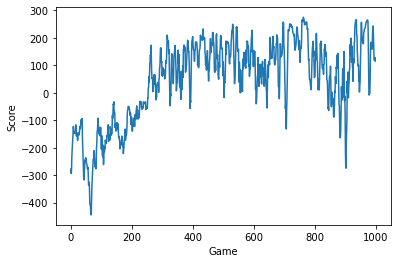

In [9]:
agent = Agent(alpha = 0.000025, beta = 0.00025, input_dims=[8], tau = 0.001, env = env, batch_size=64, layer1_size=400, layer2_size=300, n_actions=2)
np.random.seed(0)
score_history = []

for i in range(1000):
    score = 0
    done = False
    observation = env.reset()

    while not done:
        a = agent.choose_action(observation)
        new_state, reward, done, _ = env.step(a)
        agent.remember(observation, a, reward, new_state, done)
        agent.learn()
        score+=reward
        observation = new_state
    
    score_history.append(score)
    print(f'episode : {i}, score: .%2f{score}, 100 game average: %.2f{np.mean(score_history[-100:])}')

    if i%25==0:
        agent.save_models()
    
filename = 'lunar-lander.png'
plotLearning(score_history, filename)
